# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 36

**Author 1 (sciper):** Ke Wang (326760)  
**Author 2 (sciper):** Jiaan Zhu (325421)   
**Author 3 (sciper):** Rémy Dornier (271174)    

**Release date:** 23.04.2021  
**Due date:** 07.05.2021 


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the analytical expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data.
For simplicity reasons, round the estimated parameters to the closest integer value.

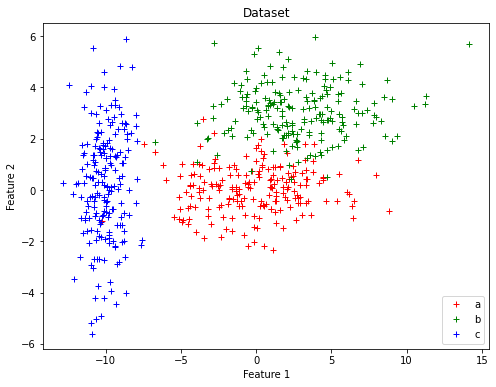

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sympy import *

# plot the given data set
plt.figure(figsize = (8,6))
plt.plot(a[:,0], a[:,1], color = 'r', linestyle = '', marker = '+', label = 'a')
plt.plot(b[:,0], b[:,1], color = 'g', linestyle = '', marker = '+', label = 'b')
plt.plot(c[:,0], c[:,1], color = 'b', linestyle = '', marker = '+', label = 'c')
plt.legend(loc = 'lower right')
plt.title('Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#### Hypothsis

We make the following hypothesis: the sample points from each group are independently Gaussian distributed 

We use Henze-Zirkler multivariate normality test to test whether a sample differs from a normal distribution. The null hypothesis that a sample comes from a normal distribution.

As shown below, P values are all greater than 0.05, so three groups of samples are all normal distributions.

In [4]:
from pingouin import multivariate_normality

print(multivariate_normality(a, alpha=.05))
print(multivariate_normality(b, alpha=.05))
print(multivariate_normality(c, alpha=.05))

HZResults(hz=0.5393399744748284, pval=0.6484443193667846, normal=True)
HZResults(hz=0.5990511126254039, pval=0.5224272512722594, normal=True)
HZResults(hz=0.43580364906111724, pval=0.8509771218027213, normal=True)


#### "Discriminant_analytic" function

Returns the corresponding analytic discriminant function $g_i(x,y)$ according to the chosen distance metrics.

- full : $g_i(\textbf{x}) = -\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_i})^T\boldsymbol{\Sigma_i^{-1}}(\textbf{x}-\boldsymbol{\mu_i}) + \ln p(w_i) + \ln \frac{1}{2\pi|\boldsymbol{\Sigma_i}|^{1/2}}$

- mahanalobis = $g_i(\textbf{x}) =[(\textbf{x}-\boldsymbol{\mu_i})^T\boldsymbol{\Sigma_i^{-1}}(\textbf{x}-\boldsymbol{\mu_i})]^{1/2}$

- euclidean = $g_i(\textbf{x}) = ||\textbf{x}-\boldsymbol{\mu_i}||$
    
 
#### inputs
 
    - mu : mean vector of class i
    - cov : covariance matrix of class i
    - prob : probability of the class i
    - distance : type of discriminant function : 'full', 'mahanalobis' or 'euclidean'

#### outputs
 
    - g : the analytic disciminant function of class i

In [5]:
def Discriminant_analytic(mu, cov, prob, distance):
    x, y = symbols('x y')
    z = np.array([x, y])
    
    if distance == 'full':
        cst = np.log(prob) + np.log(1 / (2 * np.pi * pow(abs(np.linalg.det(cov)), 0.5)))
        g = - 0.5 * np.dot(z - mu, np.linalg.inv(cov)).dot((z - mu).T) + cst
    if distance == "mahanalobis":
        g = (np.dot(z - mu, np.linalg.inv(cov)).dot((z - mu).T))**(1/2)
    if distance == 'euclidean':
        g = ((z - mu).dot((z - mu).T))**(1/2)
        
    return g

#### "boundary_equation" function

From 2 classes (i and j), it computes the analytical expression of the decision boundary quatrics as well as the analytical expression for the discriminant function $G(x,y) = g_i(x,y) - g_j(x,y)$.
 
#### inputs
 
    - data_set_1 : first class
    - data_set_2 : second class
    - nb_point_data_set : total number of points in the entire data set
    - distance : type of discriminant function : 'full', 'mahanalobis' or 'euclidean'

#### outputs
 
    - boundary : analytical expression of the decision boundary quatric, expressed in function y = f(x)
    - eq : analytical expression of the discriminant function G(x,y)


In [6]:
def boundary_equation(data_set_1, data_set_2, nb_point_data_set, distance):
        # first class mean vector, covariance matrix and probability
        mu1 = np.round(np.mean(data_set_1, 0))
        cov1 = np.round(np.cov(np.transpose(data_set_1)))
        prob1 = data_set_1[:,0].size / nb_point_data_set
        
        # second class mean vector, covariance matrix and probability
        mu2 = np.round(np.mean(data_set_2, 0))
        cov2 = np.round(np.cov(np.transpose(data_set_2)))
        prob2 = data_set_2[:,0].size / nb_point_data_set
        
        # compute the analytical expression of the discriminant function for each class
        eq1 = Discriminant_analytic(mu1, cov1, prob1, distance)
        eq2 = Discriminant_analytic(mu2, cov2, prob2, distance)
        x, y = symbols('x y')
        
        # find the analytical expression of the boundary line
        boundary = solve(Eq(eq1, eq2), y)
        
        # compute the analytical expression of the discriminant function
        eq = eq1 - eq2
        
        return [boundary, eq]

#### "bayesian_classifier" function

Performs the bayesian classification according to the previously mentionned equations. Analytical equations of the discriminant functions and the decision boundaries are built and solved. 
 
As suggested in the assignment, values of the mean vector and covariance matrices are rounded to the closest integer value.

#### inputs
 
    - data_set
    - grid_scale : sampling factor on coordinates to have better precision on separation line localization
    - T_bound : Threshold on the final separation matrix
    - labels : classes label
    - distance : type of discriminant function : 'full', 'mahanalobis' or 'euclidean'

#### outputs
 
    - X_bound : x-coordinate of the separation line
    - Y_bound : y-coordinate of the separation line
    - labels_graph : string with each possible class combinaisons
    - boundary : analytical expression of the discriminant functions and the boundary lines

In [7]:
def bayesian_classifier(data_set, labels, distance):
    # initialization
    labels_graph = []
    boundary = []
    
    nb_class = data_set.shape[2]
   
    for i in range(nb_class - 1):
        for j in range(nb_class - i - 1):
            # write down the two current classes
            labels_graph.append('{}/{}'.format(labels[i], labels[i + j + 1]))
            
            # compute the analytical expression of the boundary (solution and discriminant function)
            boundary.append(boundary_equation(data_set[:,:,i], data_set[:,:,j + i + 1], data_set[:,0,:].size, distance))
    
    return labels_graph, boundary

#### "compute_accuracy" function

From classes in the data set, it computes the percentage of points correctly classified for each class combinaison. For exemple,

- $\text{accuracy(a/b)} = \frac{\text{nb_points_correctly_classified_in_a } + \text{ nb_points_correctly_classified_in_b}}{\text{total_nb_points_in_a_and_b}}$. 

It first evaluates the disciminant function $G(x,y)$, given in 'equations', at each point of the two current data sets. Then, the classification is performed by assigning 0 to points that are misclassified and 1 to those that are correctly classified. By summing the number of '1' and dividing by the total nomber of points in both classes, the accuracy is computed for the current class combinaison.

#### inputs
 
    - data_set.
    - equations : set of analytical discriminant function G(x,y) for each couple of data set classes
    - distance : type of discriminant function : 'full', 'mahanalobis' or 'euclidean'

#### outputs
 
    - accuracy : percentage of points correctly classifed for each class combinaison 

In [8]:
def compute_accuracy(data_set, equations, distance):
    nb_class = data_set.shape[2]
    x, y = symbols('x y')
    accuracy = []
    
    for i in range(nb_class - 1):
        for j in range(nb_class - i - 1):
            # create a model to evaluate the equation on x and y 
            f = lambdify([x,y], equations[j + (nb_class - i - 1) * i][1])
            
            # evaluate the equation with data_set coordinates x and y
            class_1 = f(data_set[:,0,i], data_set[:,1,i])
            class_2 = f(data_set[:,0,i + j + 1], data_set[:,1,i + j + 1])
            
            # performs the classification (1 and 0 to compute the mean)
            class_1[class_1 > 0] = 1
            class_1[class_1 <= 0] = 0
            
            class_2[class_2 >= 0] = 0
            class_2[class_2 < 0] = 1
            
            # % of points correctly classified in both classes
            accuracy.append((sum(class_2) + sum(class_1))/(len(class_2) + len(class_1)))
    
    # take into account the '-' of the formula
    if distance == 'full':
        return accuracy
    else:
        return 1 - np.array(accuracy)

Judging from the points distribution inside classes, we may infer the following assumptions :

- classes follow a normal distribution of dimension l = 2, given by the following formula : 
$ p(\textbf{x}|w_i) = \frac{1}{2\pi|\boldsymbol{\Sigma_i}|^{1/2}} e^{0.5(\textbf{x}-\boldsymbol{\mu_i})^T\boldsymbol{\Sigma_i^{-1}}(\textbf{x}-\boldsymbol{\mu_i})}$. This is actually proved above using the Henze-Zirkler normality test.


- classes a and b have the same covariance matrix

In order to separate classes and find a classification rule for new points, the Bayes rule is implemented. The boundary of two classes i and j is determined by: 

- $p(\textbf{x}|w_i)p(w_i) = p(\textbf{x}|w_j)p(w_j)$


with $p(w_i) = n_i/n_{tot}$, the ratio of the number of elements in classe i and the total number of elements, under the assumption that points were randomly and uniformely sampled from reality, which we suppose to be the case.

The discriminant function, $g_i(\textbf{x}) = p(\textbf{x}|w_i)p(w_i)$, can be re-written under normal approximation of dimension l = 2 as
- $g_i(\textbf{x}) = -\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_i})^T\boldsymbol{\Sigma_i^{-1}}(\textbf{x}-\boldsymbol{\mu_i}) + \ln p(w_i) + \ln \frac{1}{2\pi|\boldsymbol{\Sigma_i}|^{1/2}}$ for the boundary between class a/c and b/c

- $g_i(\textbf{x}) = (\boldsymbol{\Sigma_i^{-1}}\boldsymbol{\mu_i})^T \textbf{x} + \ln p(w_i) - \frac{1}{2}\boldsymbol{\mu_i}^T\boldsymbol{\Sigma_i^{-1}}\boldsymbol{\mu_i}$ for the boundary between class a/b

The decision boundaries quatrics are then computed as $g_i(\textbf{x}) - g_j(\textbf{x}) = 0$

The results below show the 2 quatratic boundaries between class a/c and b/c and the linear one between class a/b.
When displaying the analytical equation of quatratic decision boundaries, two solutions are coming up (which is completely normal). The one that is interesting for us (i.e. corresponding to the boundary displayed on the graph) is the second one.

a/b boundary equation : y = [1.65 - 0.1*x]
accuracy of class a/b : 0.9525

a/c boundary equation : y = [-11.1415244030743*sqrt(0.00906281867210496*x**2 + 0.201395970491221*x + 1.0), 11.1415244030743*sqrt(0.00906281867210496*x**2 + 0.201395970491221*x + 1.0)]
accuracy of class a/c : 0.995

b/c boundary equation : y = [3.75 - 11.2169989758536*sqrt(0.00894126902233308*x**2 + 0.204655713177846*x + 1), 11.2169989758536*sqrt(0.00894126902233308*x**2 + 0.204655713177846*x + 1) + 3.75]
accuracy of class b/c : 1.0



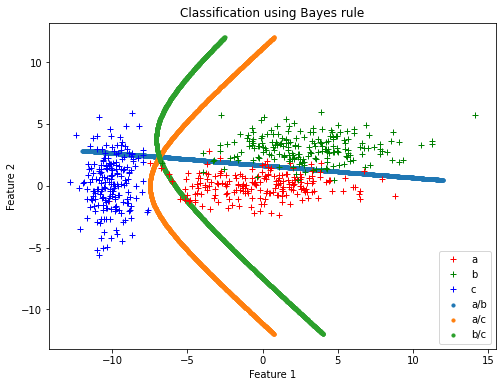

In [9]:
# stack data sets a, b and c in one big data set
data_set_ab = np.dstack((a, b))
data_set_abc = np.dstack((data_set_ab, c))

# initialization
grid_fact = 30
T_bound = 0.1
labels = ['a', 'b', 'c']
colors = ['r', 'g', 'b']
distance = 'full' # distance metrics corresponding to bayes rule

# run bayesian classification with 'full' distance metrics
labels_graph, boundary = bayesian_classifier(data_set_abc, labels, distance)

# compute classification accuracy
accuracy = compute_accuracy(data_set_abc, boundary, distance)

plt.figure(figsize = (8,6))

# plot data sets a, b and c 
for i in range(len(labels)):
    plt.plot(data_set_abc[:,0,i], data_set_abc[:,1,i], color = colors[i], linestyle = '', marker = '+', label = labels[i])

x, y = symbols('x y')
     
# plot the decision boundary lines
for i in range(len(labels_graph)):
    p = plot_implicit(boundary[i][1], (x, -12, 12), (y, -12, 12), show = False)
    series = p[0]
    data, action = series.get_points()
    curve = np.array([(x_int.mid, y_int.mid) for x_int, y_int in data])
    plt.scatter(curve[:,0], curve[:,1],label = labels_graph[i], s = 10)
    
    # display boundary equation and classification accuracy
    print('{} boundary equation : y = {}' .format(labels_graph[i], boundary[i][0]))
    print('accuracy of class {} : {}\n'.format(labels_graph[i], accuracy[i]))
    
plt.legend(loc = 'lower right')
plt.title('Classification using Bayes rule')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

For classes a and b, follwing assumptions can be made (recalled from above) :
     
     - Normal distibution for both classes.
     - Same covariance matrix but not diagonal

Under that assumptions, the mahanalobis distance can be used to classify points : $d_{m_i} = ((\textbf{x}-\boldsymbol{\mu_i})\boldsymbol{\Sigma_i}^{-1}(\textbf{x}-\boldsymbol{\mu_i}))^{1/2}$. Therefore, the decision boundary is linear.

A comparison with the bayes formula for the decision boundary is shown on separate graphs. Assumptions look correct because results are identical ; boundaries have the same equation. This is completely normal under the assumptions we have made. Indeed,

- $p(a) = p(b)$ and $\Sigma_a = \Sigma_b$. 
- So, $-\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_a})^T\boldsymbol{\Sigma_a^{-1}}(\textbf{x}-\boldsymbol{\mu_a}) + \ln p(a) + \ln \frac{1}{2\pi|\boldsymbol{\Sigma_a}|^{1/2}} = -\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_b})^T\boldsymbol{\Sigma_b^{-1}}(\textbf{x}-\boldsymbol{\mu_b}) + \ln p(b) + \ln \frac{1}{2\pi|\boldsymbol{\Sigma_b}|^{1/2}}$.
- $-\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_a})^T\boldsymbol{\Sigma_a^{-1}}(\textbf{x}-\boldsymbol{\mu_a}) = -\frac{1}{2}(\textbf{x}-\boldsymbol{\mu_b})^T\boldsymbol{\Sigma_b^{-1}}(\textbf{x}-\boldsymbol{\mu_b})$ because of first conditions.
- $(\textbf{x}-\boldsymbol{\mu_a})^T\boldsymbol{\Sigma_a^{-1}}(\textbf{x}-\boldsymbol{\mu_a}) = (\textbf{x}-\boldsymbol{\mu_b})^T\boldsymbol{\Sigma_b^{-1}}(\textbf{x}-\boldsymbol{\mu_b})$ 
- $d_{m_a}^2 = d_{m_b}^2$

If we suppose now that the covariance matrices are diagonal (which is of course not the case), then the euclidean distance can be used as a point classifier : $d_e = ||\textbf{x}-\boldsymbol{\mu_i}||$. The boundary is still a line but perpendicular to the line passing through the mean's center of each of the two classes. The results is also presented below as comparison : the classification is not correct and the accuracy is low compared to the mahanalobis distance classification. This confirms that the covariance matrices are not diagonal. 

a/b equation for full distance metrics : y = [1.65 - 0.1*x]
accuracy of class a/b : 0.9525

a/b equation for mahanalobis distance metrics : y = [1.65 - 0.1*x]
accuracy of class a/b : 0.9525

a/b equation for euclidean distance metrics : y = [3.0 - x]
accuracy of class a/b : 0.8375



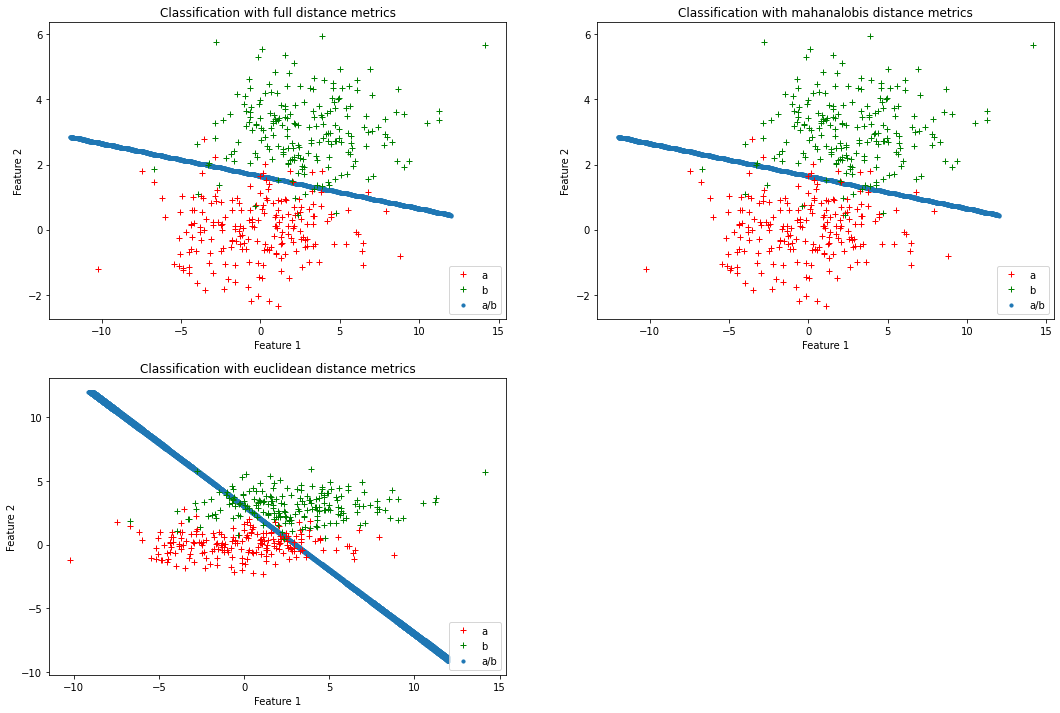

In [10]:
# initialization
labels = ['a', 'b']
colors = ['r', 'g']
distance_metric = ['full', 'mahanalobis', 'euclidean']
T_bound = 0.08

# plot the data sets a / b and boundary for full distance metrics
plt.figure(figsize = (18,12))

for i in range(len(distance_metric)) :
    # run bayesian classification for three types of distances for data sets a and b
    labels_graph, boundary = bayesian_classifier(data_set_ab, labels, distance_metric[i])
    
    # compute accuracy (% of points that are well classified)
    accuracy = compute_accuracy(data_set_ab, boundary, distance_metric[i])

    plt.subplot(2,2,i + 1)
    
    # plot original dataset (a and b)
    for class_i in range(len(labels)):
        plt.plot(data_set_ab[:,0,class_i], data_set_ab[:,1,class_i], 
                 color = colors[class_i], linestyle = '', marker = '+', label = labels[class_i])
    
    # plot boundary 
    for bound_i in range(len(labels_graph)):
        p = plot_implicit(boundary[bound_i][1], (x, -12, 12), (y, -12, 12), show = False)
        series = p[0]
        data, action = series.get_points()
        curve = np.array([(x_int.mid, y_int.mid) for x_int, y_int in data])
        plt.scatter(curve[:,0], curve[:,1],label = labels_graph[bound_i], s = 10)
        
        # display boundary equation and classification accuracy
        print('{} equation for {} distance metrics : y = {}' .format(labels_graph[bound_i], distance_metric[i],
                                                                     boundary[bound_i][0]))
        print('accuracy of class {} : {}\n'.format(labels_graph[bound_i], accuracy[bound_i]))
    
    plt.legend(loc = 'lower right')
    plt.title('Classification with {} distance metrics' .format(distance_metric[i]))
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
plt.show()

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [11]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)
    return labels

In [12]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

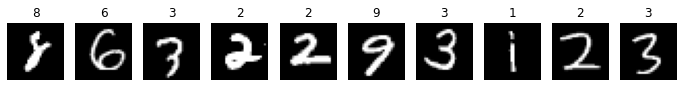

In [13]:
prng = np.random.RandomState(seed = 123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low = 0, high = train_set_size, size = 10)

fig, axes = plt.subplots(1, 10, figsize = (12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap = 'gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

Images for training and testing set are coming from http://yann.lecun.com/exdb/mnist/. 

Here, we chose to use the SKlearn package, and 'adam' optimizer to train the classifier and predict the classification.

In [14]:
from sklearn.neural_network import MLPClassifier

training_vector = np.reshape(train_images, (len(train_images), -1))

# define the classifier
clf = MLPClassifier(solver = 'adam', alpha = 1e-5, hidden_layer_sizes = 100, random_state = 1)

# train the classifier 
_ = clf.fit(training_vector, train_labels) 

In [15]:
print('Size of the training set (nb_samples x visible_units) : {} x {}' .format(len(training_vector), len(training_vector[0])))
print('Number of layers : {}' .format(clf.n_layers_))
print('Hidden layer size : {}' .format(clf.hidden_layer_sizes))
print('Number of output units : {}' .format(clf.n_outputs_))
print('Number of iterations : {}' .format(clf.n_iter_))

Size of the training set (nb_samples x visible_units) : 60000 x 784
Number of layers : 3
Hidden layer size : 100
Number of output units : 10
Number of iterations : 77


In [16]:
# predict classification for both training and testing set
testing_vector = np.reshape(test_images, (len(test_images), -1))
prediction_test = clf.predict(testing_vector) 
prediction_train  = clf.predict(training_vector)

# compute the accuracy of classification (% of the points correctly classified)
acc_test = np.mean(prediction_test == test_labels)
acc_train = np.mean(prediction_train == train_labels)

print('Size of the testing set (nb_samples x visible_units) : {} x {}' .format(len(testing_vector), len(testing_vector[0])))
print('accuracy of the training set : {}' .format(acc_train))
print('accuracy of the testing set : {}' .format(acc_test))

Size of the testing set (nb_samples x visible_units) : 10000 x 784
accuracy of the training set : 0.9958
accuracy of the testing set : 0.968
